In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.optimize as sco
import matplotlib.pyplot as plt
import random

In [9]:
from sx_centre import *
hq=HqReader("sx_002","gssx0002")
sql='SELECT date,stock_code,EGRO,EGIB,EPIBS,SGRO FROM barra_sto where date between "2016-01-01" and "2019-07-01" '
alpha_df=hq.get_factor_data(sql)

SQL:		SELECT date,stock_code,EGRO,EGIB,EPIBS,SGRO FROM barra_sto where date between "2016-01-01" and "2019-07-01" 


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\engine\base.py", line 2158, in _wrap_pool_connect
    return fn()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\pool.py", line 403, in connect
    return _ConnectionFairy._checkout(self)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\pool.py", line 788, in _checkout
    fairy = _ConnectionRecord.checkout(pool)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\pool.py", line 532, in checkout
    rec = pool._do_get()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\pool.py", line 1193, in _do_get
    self._dec_overflow()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\util\langhelpers.py", line 66, in __exit__
    compat.reraise(exc_type, exc_value, exc_tb)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\util\compat.py", line 187, in reraise
    raise value
  File "C:\ProgramData\Anaconda3\lib\site-packages\sq

OperationalError: (pymysql.err.OperationalError) (1045, "Access denied for user 'sx_002'@'115.197.184.247' (using password: YES)") (Background on this error at: http://sqlalche.me/e/e3q8)

In [2]:
def zjh(arr):
    arr_t=arr.transpose()

    #计算重叠矩阵
    overlap_matrix=np.dot(arr_t,arr)
    overlap_matrix=(overlap_matrix.T+overlap_matrix)/2
    #计算特征值、特征向量
    eigvalue,eigvector=np.linalg.eig(overlap_matrix)

    #处理对角矩阵
    eigvalue=eigvalue**(-0.5)
    DiagMat=np.diag(eigvalue)

    #计算最终正交矩阵
    tmp=np.dot(eigvector,DiagMat)
    TSMat=np.dot(tmp,eigvector.transpose())
    OrthMat=np.dot(arr,TSMat)
    
    return OrthMat

def data_handle(mat):
    for i in range(mat.shape[1]):
        arr = np.array(mat[:,i])
        M = np.median(arr)
        MAD = 1.483 * np.median(np.abs(arr - M))
        arr[arr > M + 3 * MAD] = M + 3 * MAD
        arr[arr < M - 3 * MAD] = M - 3 * MAD
        mat[:,i] = arr
            
    for i in range(mat.shape[1]):
        arr = np.array(mat[:,i])
        weight = np.array(len(arr) * [1 / len(arr)])
        weighted_avarage = np.dot(weight.T, arr)
        arr = (arr - weighted_avarage) / arr.std()
        mat[:,i] = arr
    return mat

In [3]:
#数据处理
change_data_1=pd.read_csv("change.csv",dtype={"stock_code":str})
change_data_2=pd.read_csv("change_2.csv",dtype={"stock_code":str})
change_data=pd.concat([change_data_1,change_data_2])

change_data.rename(columns={"stock_code":"code","trade_date":"datetime"},inplace=True)
change_data["datetime"]=change_data["datetime"].apply(lambda x:x[0:10])
change_data["code"]=change_data["code"].apply(lambda x:x+".SH" if x[0]=="6" else x+".SZ")

change_data.sort_values(by=["datetime","code"],ascending=[True,True],inplace=True)

change_data.set_index("code",inplace=True)

grouped=change_data.groupby("datetime")
date_list=list(change_data["datetime"].drop_duplicates())
code_list=list(change_data.index.drop_duplicates())
join=set(code_list)
union=set(code_list)
for date in date_list:
    df=grouped.get_group(date)
    stock_set=set(df.index)
    join=stock_set&join
    union=stock_set|union
other_list=list(union-join)
change_data.drop(other_list,inplace=True)

drop_list=random.sample(list(join),1135)
change_data.drop(drop_list,inplace=True)

change_data.reset_index(inplace=True)


data=pd.read_csv("data_needs.csv")
date=list(data["datetime"].drop_duplicates())[-1]
df=data.groupby("datetime").get_group(date)
dic=dict(zip(df["code"],df["industry_code"]))
change_data["industry_code"]=change_data["code"].apply(lambda x:dic.get(x,0))

drop_list=list(set(change_data["code"][change_data["industry_code"]==0]))
change_data.set_index("code",inplace=True)
change_data.drop(drop_list,inplace=True)
change_data.reset_index(inplace=True)

stock_ret_df=change_data.pivot_table("change_rate",index="datetime",columns="code")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [4]:
alpha_df=pd.read_csv("growth_factor.csv")
del alpha_df["industry_code"]

code_list=list(alpha_df["code"].drop_duplicates())
alpha_df.set_index("code",inplace=True)

drop_code=set(code_list)-set(stock_ret_df.columns)
alpha_df.drop(drop_code,inplace=True)

alpha_df.reset_index()

alpha_df.sort_values(by=["datetime","code"],ascending=[True,True],inplace=True)

alpha_df=pd.merge(alpha_df,change_data,on=["datetime","code"])
alpha_df.fillna(0,inplace=True)

In [5]:
mcap_data_1=pd.read_csv("mcap.csv",dtype={"stock_code":str})
mcap_data_2=pd.read_csv("mcap_2.csv",dtype={"stock_code":str})
mcap_data=pd.concat([mcap_data_1,mcap_data_2])

mcap_data.rename(columns={"stock_code":"code","trade_date":"datetime"},inplace=True)
mcap_data["datetime"]=mcap_data["datetime"].apply(lambda x:x[0:10])
mcap_data["code"]=mcap_data["code"].apply(lambda x:x+".SH" if x[0]=="6" else x+".SZ")

new_alpha_df=pd.merge(alpha_df,mcap_data,on=["datetime","code"])

In [6]:
ret_df=stock_ret_df

for code in ret_df.columns:
    ret_df[code+"_In_change"]=np.array(np.log(1+ret_df[code]/100))[::-1]
    ret_df[code+"_21d_ret"]=(np.array(np.exp(ret_df[code+"_In_change"].rolling(21).apply(np.sum)))[::-1]-1)*100
    ret_df[code+"_21d_ret"]=ret_df[code+"_21d_ret"].shift(-1)
    del ret_df[code+"_In_change"]

stock_num=len(stock_ret_df.columns)
df=pd.DataFrame(stock_ret_df.iloc[:,int(stock_num/2):stock_num]).stack()

df=df.reset_index()
df["code"]=df["code"].apply(lambda x:x[0:9])
new_alpha_df=pd.merge(new_alpha_df,df,on=["datetime","code"])
new_alpha_df.rename(columns={0:"21d_ret"},inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


In [7]:
zz500=pd.read_csv("zz500.csv")
zz500["In_change"]=np.array(np.log(1+zz500["change_rate"]/100))[::-1]
zz500["21d_ret"]=(np.array(np.exp(zz500["In_change"].rolling(21).apply(np.sum)))[::-1]-1)*100
zz500["21d_ret"]=zz500["21d_ret"].shift(-1)


zz500.rename(columns={"21d_ret":"mkt_ret","trade_date":"datetime"},inplace=True)
zz500["datetime"]=zz500["datetime"].apply(lambda x:x[0:10])
del zz500["index_code"]
del zz500["In_change"]
del zz500["change_rate"]
new_alpha_df=pd.merge(new_alpha_df,zz500,on="datetime")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
new_alpha_df

,datetime,code,EGRO,EGIB,EPIBS,SGRO,change_rate,industry_code,mcap,21d_ret,mkt_ret
0,2016-01-04,000004.SZ,16.712214,75.7738,295.2824,15.322476,-10.0000,801150,3.464966e+05,-29.072905,-20.001327
1,2016-01-04,000006.SZ,-9.270327,19.7893,23.5909,-12.994028,-9.8175,801180,1.401295e+06,-28.131127,-20.001327
2,2016-01-04,000011.SZ,5.455108,-48.0903,69.2267,-17.447758,-9.9862,801180,2.298525e+05,-23.335887,-20.001327
3,2016-01-04,000012.SZ,78.321468,-7.8244,42.7606,0.357825,-9.9625,801710,1.578060e+06,-13.144555,-20.001327
4,2016-01-04,000016.SZ,7.156540,86.4814,82.9333,2.917511,-9.9855,801110,7.463731e+05,-33.440556,-20.001327
5,2016-01-04,000020.SZ,58.022820,86.3332,286.7444,31.266209,-9.6257,801080,4.898712e+05,-26.035513,-20.001327
6,2016-01-04,000023.SZ,82.621530,267.6197,66.3696,11.544278,0.0000,801710,4.236228e+05,0.000000,-20.001327
7,2016-01-04,000026.SZ,12.029258,14.6940,36.7673,4.117979,-10.0122,801140,4.585907e+05,-29.240170,-20.001327
8,2016-01-04,000027.SZ,45.195719,3.5366,17.3333,-1.264732,-9.8879,801160,1.270772e+06,-25.792033,-20.001327
9,2016-01-04,000035.SZ,10.242741,35.9896,37.9106,172.047142,0.0000,801160,6.229042e+05,0.000000,-20.001327


In [17]:
date_list=list(new_alpha_df["datetime"].drop_duplicates())
code_list=list(new_alpha_df["code"].drop_duplicates())

In [21]:
date_list=date_list[:-21]
factor_list=["EGRO","EGIB","EPIBS","SGRO"]
factor_ret_df=pd.DataFrame(columns=factor_list,index=date_list)

In [22]:
alpha_df=new_alpha_df
grouped=alpha_df.groupby("datetime")

for date in date_list:
    df=grouped.get_group(date)

    mktv=np.array(df["mcap"])
    mktv_pct=np.sqrt(mktv)/np.sum(np.sqrt(mktv))
    weight=mktv_pct**(0.5)
    
    y=np.array(df["21d_ret"]-df["mkt_ret"])
    y=np.dot(np.diag(weight),y)
    
    indus_factor=np.array(sm.categorical(np.array(df["industry_code"])))[:, 1:]
    style_factor=np.array(df[factor_list])
    style_factor=data_handle(zjh(data_handle(style_factor)))
    x=np.column_stack([style_factor,indus_factor])
    x=np.dot(np.diag(weight),x)
    
    model=sm.OLS(y,x)
    result=model.fit()
    factor_ret=result.params[0:4]
    factor_ret_df.loc[date]=factor_ret

In [23]:
factor_ret_df=pd.concat([factor_ret_df,pd.DataFrame(columns=range(12),index=date_list)],axis=1)

In [24]:
for i in range(251,len(date_list)-21):
    window=range(i-251,i+1)
    sub_df=factor_ret_df.iloc[window,0:4]
    factor_ret_mean=np.array(sub_df.apply(np.mean,axis=0))
    factor_ret_df.iloc[i+21,4:8]=np.abs(factor_ret_mean)/np.sum(np.abs(factor_ret_mean))
    
    factor_ret_std=np.array(sub_df.apply(np.std,axis=0))
    factor_ret_df.iloc[i+21,8:12]=np.abs(factor_ret_std**-1)/np.sum(np.abs(factor_ret_std**-1))
    
    factor_ret_df.iloc[i+21,12:16]=np.array([0.18,0.11,0.24,0.47])


In [25]:
R_square_df=pd.DataFrame(index=date_list[272:len(date_list)-21],columns=["mean_weight","var_weight","fixed_weight"])

In [26]:
for date in date_list[272:len(date_list)-21]:
    print(date,end=" ")
    df=grouped.get_group(date)

    mktv=np.array(df["mcap"])
    mktv_pct=np.sqrt(mktv)/np.sum(np.sqrt(mktv))
    weight=mktv_pct**(0.5)
    
    y=np.array(df["21d_ret"]-df["mkt_ret"])
    y=np.dot(np.diag(weight),y)
    
    indus_factor=np.array(sm.categorical(np.array(df["industry_code"])))[:, 1:]
    
    
    #因子收益率均值作为因子权重
    style_factor=np.array(df[factor_list])
    factor_weight=np.array(factor_ret_df.ix[date,4:8])
    new_factor=np.dot(style_factor,factor_weight.T)
    new_factor=data_handle(new_factor.reshape(len(new_factor),1))
    x=np.column_stack([new_factor,indus_factor])
    x=np.dot(np.diag(weight),x)
    x=np.array(x,dtype=float)
    
    model=sm.OLS(y,x)
    result=model.fit()
    R_square=result.rsquared_adj
    R_square_df.loc[date,"mean_weight"]=R_square
    
    
    #因子收益率波动率倒数作为因子权重
    style_factor=np.array(df[factor_list])
    factor_weight=np.array(factor_ret_df.ix[date,8:12])
    new_factor=np.dot(style_factor,factor_weight.T)
    new_factor=data_handle(new_factor.reshape(len(new_factor),1))
    x=np.column_stack([new_factor,indus_factor])
    x=np.dot(np.diag(weight),x)
    x=np.array(x,dtype=float)
    
    model=sm.OLS(y,x)
    result=model.fit()
    R_square=result.rsquared_adj
    R_square_df.loc[date,"var_weight"]=R_square
    
    
    #固定权重
    style_factor=np.array(df[factor_list])
    factor_weight=np.array(factor_ret_df.ix[date,12:16])
    new_factor=np.dot(style_factor,factor_weight.T)
    new_factor=data_handle(new_factor.reshape(len(new_factor),1))
    x=np.column_stack([new_factor,indus_factor])
    x=np.dot(np.diag(weight),x)
    x=np.array(x,dtype=float)
    
    model=sm.OLS(y,x)
    result=model.fit()
    R_square=result.rsquared_adj
    R_square_df.loc[date,"fixed_weight"]=R_square

    

2017-02-17 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


2017-02-20 2017-02-21 2017-02-22 2017-02-23 2017-02-24 2017-02-27 2017-02-28 2017-03-01 2017-03-02 2017-03-03 2017-03-06 2017-03-07 2017-03-08 2017-03-09 2017-03-10 2017-03-13 2017-03-14 2017-03-15 2017-03-16 2017-03-17 2017-03-20 2017-03-21 2017-03-22 2017-03-23 2017-03-24 2017-03-27 2017-03-28 2017-03-29 2017-03-30 2017-03-31 2017-04-05 2017-04-06 2017-04-07 2017-04-10 2017-04-11 2017-04-12 2017-04-13 2017-04-14 2017-04-17 2017-04-18 2017-04-19 2017-04-20 2017-04-21 2017-04-24 2017-04-25 2017-04-26 2017-04-27 2017-04-28 2017-05-02 2017-05-03 2017-05-04 2017-05-05 2017-05-08 2017-05-09 2017-05-10 2017-05-11 2017-05-12 2017-05-15 2017-05-16 2017-05-17 2017-05-18 2017-05-19 2017-05-22 2017-05-23 2017-05-24 2017-05-25 2017-05-26 2017-05-31 2017-06-01 2017-06-02 2017-06-05 2017-06-06 2017-06-07 2017-06-08 2017-06-09 2017-06-12 2017-06-13 2017-06-14 2017-06-15 2017-06-16 2017-06-19 2017-06-20 2017-06-21 2017-06-22 2017-06-23 2017-06-26 2017-06-27 2017-06-28 2017-06-29 2017-06-30 2017-07-03

In [30]:
R_square_df.mean(axis=0)

mean_weight     0.144244
var_weight      0.142502
fixed_weight    0.142907
dtype: float64

In [35]:
R_square_df.index=pd.to_datetime(R_square_df.index)

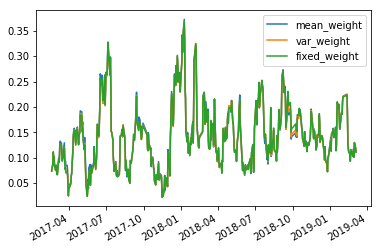

In [36]:
ax = R_square_df.plot() 
fig = ax.get_figure()
fig.savefig('R_square.jpg',dpi=500)

In [60]:
"""
Implementation of gradient descent algorithm for minimizing cost of a linear hypothesis function.
"""
import numpy

# List of input, output pairs
train_data = (((5, 2, 3), 15), ((6, 5, 9), 25),
              ((11, 12, 13), 41), ((1, 1, 1), 8), ((11, 12, 13), 41))
test_data = (((515, 22, 13), 555), ((61, 35, 49), 150))
parameter_vector = [2, 4, 1, 5]
m = len(train_data)
LEARNING_RATE = 0.009


def _error(example_no, data_set='train'):
    """
    :param data_set: train data or test data
    :param example_no: example number whose error has to be checked
    :return: error in example pointed by example number.
    """
    return calculate_hypothesis_value(example_no, data_set) - output(example_no, data_set)


def _hypothesis_value(data_input_tuple):
    """
    Calculates hypothesis function value for a given input
    :param data_input_tuple: Input tuple of a particular example
    :return: Value of hypothesis function at that point.
    Note that there is an 'biased input' whose value is fixed as 1.
    It is not explicitly mentioned in input data.. But, ML hypothesis functions use it.
    So, we have to take care of it separately. Line 36 takes care of it.
    """
    hyp_val = 0
    for i in range(len(parameter_vector) - 1):
        hyp_val += data_input_tuple[i]*parameter_vector[i+1]
    hyp_val += parameter_vector[0]
    return hyp_val


def output(example_no, data_set):
    """
    :param data_set: test data or train data
    :param example_no: example whose output is to be fetched
    :return: output for that example
    """
    if data_set == 'train':
        return train_data[example_no][1]
    elif data_set == 'test':
        return test_data[example_no][1]


def calculate_hypothesis_value(example_no, data_set):
    """
    Calculates hypothesis value for a given example
    :param data_set: test data or train_data
    :param example_no: example whose hypothesis value is to be calculated
    :return: hypothesis value for that example
    """
    if data_set == "train":
        return _hypothesis_value(train_data[example_no][0])
    elif data_set == "test":
        return _hypothesis_value(test_data[example_no][0])


def summation_of_cost_derivative(index, end=m):
    """
    Calculates the sum of cost function derivative
    :param index: index wrt derivative is being calculated
    :param end: value where summation ends, default is m, number of examples
    :return: Returns the summation of cost derivative
    Note: If index is -1, this means we are calculating summation wrt to biased parameter.
    """
    summation_value = 0
    for i in range(end):
        if index == -1:
            summation_value += _error(i)
        else:
            summation_value += _error(i)*train_data[i][0][index]
    return summation_value


def get_cost_derivative(index):
    """
    :param index: index of the parameter vector wrt to derivative is to be calculated
    :return: derivative wrt to that index
    Note: If index is -1, this means we are calculating summation wrt to biased parameter.
    """
    cost_derivative_value = summation_of_cost_derivative(index, m)/m
    return cost_derivative_value


def run_gradient_descent():
    global parameter_vector
    # Tune these values to set a tolerance value for predicted output
    absolute_error_limit = 0.000002
    relative_error_limit = 0
    j = 0
    while True:
        j += 1
        temp_parameter_vector = [0, 0, 0, 0]
        for i in range(0, len(parameter_vector)):
            cost_derivative = get_cost_derivative(i-1)
            temp_parameter_vector[i] = parameter_vector[i] - \
                LEARNING_RATE*cost_derivative
        if numpy.allclose(parameter_vector, temp_parameter_vector,
                          atol=absolute_error_limit, rtol=relative_error_limit):
            break
        parameter_vector = temp_parameter_vector
    print(("Number of iterations:", j))


def test_gradient_descent():
    for i in range(len(test_data)):
        print(("Actual output value:", output(i, 'test')))
        print(("Hypothesis output:", calculate_hypothesis_value(i, 'test')))


if __name__ == '__main__':
    run_gradient_descent()
    print("\nTesting gradient descent for a linear hypothesis function.\n")
    test_gradient_descent()

('Number of iterations:', 5993)

Testing gradient descent for a linear hypothesis function.

('Actual output value:', 555)
('Hypothesis output:', 555.2244946726337)
('Actual output value:', 150)
('Hypothesis output:', 150.01694829900705)
('Number of iterations:', 5993)

Testing gradient descent for a linear hypothesis function.

('Actual output value:', 555)
('Hypothesis output:', 555.2244946726337)
('Actual output value:', 150)
('Hypothesis output:', 150.01694829900705)
